In [64]:
import pandas as pd
import numpy as np
import xarray as xr
import netCDF4 as nf4
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime
from cftime import DatetimeNoLeap
import datetime as dt

# import os, sys
# dir2 = os.path.abspath('')
# dir1 = os.path.dirname(dir2)
# if not dir1 in sys.path: sys.path.append(dir1)
from utils.processing import ibtracs_vars

from sklearn.metrics.pairwise import euclidean_distances, haversine_distances
import metpy as mp

#%matplotlib inline
#plt.style.use("seaborn")
#plt.rcParams["figure.figsize"] = (16, 12)

from haversine import haversine_vector, Unit

In [186]:
def read_tempest(file, colnames):
    
    # Reads in file
    df = pd.read_csv(file, sep='\s+', names=colnames)
    
    # Takes individual year, month, day, hour columns and transforms to pd.date_time column
    df['time'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']], errors='coerce')
    
    # Drops year, month, day, hour columns
    df = df[['time', 'lon_x', 'lat_y', 'lon', 'lat', 'slp', 'wsp', 'sfc_phi']]
    
    # Selects indices where a new track starts, assigns to array
    run_idx = df[df.lon_x=='start'].index.tolist()
    
    # Quantifies the max number of timesteps for all tracks
    max_tsteps = df['lat_y'].iloc[run_idx].values.max()

    # Separates dataframe into individual dataframes, split on new tracks
    dfs = [df.iloc[run_idx[n]+1:run_idx[n+1]] for n in range(len(run_idx)-1)]
    
    # Drops lon_x and lat_y columns
    dfs = [dfi[['time', 'lon', 'lat', 'slp', 'wsp', 'sfc_phi']] for dfi in dfs]
    
    # Resets index from previous dataframe splits
    dfs = [dfi.reset_index(drop=True) for dfi in dfs]
    
    # Pads dataframes with NaN rows so they're all the same length as the longest dataframe
    max_tsteps=360
    dfs = [dfi.reindex(range((max_tsteps-len(dfi))+len(dfi))) for dfi in dfs]
    
    # Converts longitude from [0, 360] to [-180, 180] 
    #for dfi in dfs:
    #    dfi['lon'] = dfi['lon'].map(lambda x: np.mod((x+180), 360)-180)
        
    # Makes sure lat, lon, wsp, slp, phi columns are floats and not str
    #for dfi
    
    return dfs

In [3]:
def calc_distance(start_pts, end_pts, method, radius=6371):
    """
    method = 'euclidean or haversine'
    radius is in km"""
    
    
    
    if method == 'euclidean' or method == 'Euclidean':
        
    elif method == 'haversine' or method == 'Haversine':
        
    else:
        print("Pick 'euclidean' or 'haversine' as the method.")

IndentationError: expected an indented block (1019680463.py, line 10)

In [ ]:
# Read in ibtracs data
ibtracs = "../tempest_extremes/IBTrACS.ALL.v04r00.nc"
ibtracs_ds = xr.open_dataset(ibtracs, drop_variables=ibtracs_vars).load()
since80_ds = ibtracs_ds.loc[dict(date_time=ibtracs_ds.date_time, storm=ibtracs_ds.storm[(ibtracs_ds['time.year'] >= 1980)[:,0]])]
since80_ds

In [187]:
# Read in TempestExtremes data
ERA5 = "../tempest_extremes/trajectories.txt.ERA5"
colnames = ['lon_x', 'lat_y', 'lon', 'lat', 'slp', 'wsp', 'sfc_phi', 'year', 'month', 'day', 'hour']
# sfc_phi = 0 over ocean, >10 over land0
ERA5_dfs = read_tempest(ERA5, colnames)

In [188]:
ERA5_dfs[0]

,time,lon,lat,slp,wsp,sfc_phi
0,1980-01-06 06:00:00,120.50,-14.25,99876.38,14.64815,0.0
1,1980-01-06 12:00:00,119.00,-14.75,99811.00,13.98848,0.0
2,1980-01-06 18:00:00,119.00,-15.00,99536.94,13.69575,0.0
3,1980-01-07 00:00:00,119.25,-15.00,99414.56,17.97812,0.0
4,1980-01-07 06:00:00,119.50,-15.50,99173.19,17.22728,0.0
...,...,...,...,...,...,...
355,NaT,NaN,NaN,NaN,NaN,NaN
356,NaT,NaN,NaN,NaN,NaN,NaN
357,NaT,NaN,NaN,NaN,NaN,NaN
358,NaT,NaN,NaN,NaN,NaN,NaN


In [189]:
# These are all the correct shape/consistent with IBTRACS data
ERA5_data = np.stack([df.values for df in ERA5_dfs])
date_time = np.dstack([pd.to_datetime(df['time'].values) for df in ERA5_dfs])[0]
#time = ERA5_data[:,:,0].astype()
time = np.stack([pd.to_datetime(df['time'].values) for df in ERA5_dfs])
lon = ERA5_data[:,:,1].astype(float)
lat = ERA5_data[:,:,2].astype(float)
slp = ERA5_data[:,:,3].astype(float)
wsp = ERA5_data[:,:,4].astype(float)
szn = np.hstack([np.datetime_as_string(df['time'].values[0], 'Y')\
           for df in ERA5_dfs]).astype(float)
#sid = 

In [190]:
# Write attributes/data descriptions later
ERA5_ds = xr.Dataset(
        data_vars=dict(
            pressure=(['storm', 'date_time'], slp, {'units':'Pa'}),
            wind_speed=(['storm', 'date_time'], wsp, {'units':'m/s'})),
        coords=dict(
            time=(['storm', 'date_time'], time),
            lon=(['storm', 'date_time'], lon),
            lat=(['storm', 'date_time'], lat)))
ERA5_ds

<xarray.Dataset>
Dimensions:     (storm: 3084, date_time: 360)
Coordinates:
    time        (storm, date_time) datetime64[ns] 1980-01-06T06:00:00 ... NaT
    lon         (storm, date_time) float64 120.5 119.0 119.0 ... nan nan nan
    lat         (storm, date_time) float64 -14.25 -14.75 -15.0 ... nan nan nan
Dimensions without coordinates: storm, date_time
Data variables:
    pressure    (storm, date_time) float64 9.988e+04 9.981e+04 ... nan nan
    wind_speed  (storm, date_time) float64 14.65 13.99 13.7 ... nan nan nan

In [199]:
distances = []
for i in range(len(ERA5_ds.storm)):
    start_coords = np.dstack((ERA5_ds.lat.sel(storm=i).data, ERA5_ds.lon.sel(storm=i).data))[0]
    end_coords = np.dstack((since80_ds.lat.sel(storm=i).data, since80_ds.lon.sel(storm=i).data))[0]
    
    dists = haversine_vector(start_coords, end_coords, unit=Unit.KILOMETERS)

    distances.append(dists)

In [167]:
haversine_vector((ERA5_ds.lat.sel(storm=0).data[0], ERA5_ds.lon.sel(storm=0).data[0]), 
                 (ibtracs_ds.lat.sel(storm=0).data[0], ibtracs_ds.lon.sel(storm=0).data[0]), unit=Unit.KILOMETERS)

array([5240.14444818])

In [202]:
dist = np.array(distances)
dist
np.where(dist<=300.)

(array([  24,   24,   24,   24,   24,   24,   24,  171,  171,  171,  171,
         177,  177,  179,  179,  307,  307,  307,  307,  307,  314,  314,
         314,  314,  314,  314,  314,  314,  314,  314,  314,  314,  314,
         321,  321,  339,  339,  339,  339,  339,  687,  687,  687,  687,
         687,  687,  687,  967,  967,  967,  967,  967,  967,  967,  967,
         967,  984,  984,  984,  984,  984,  984,  985, 1066, 1066, 1066,
        1066, 1132, 1136, 1136, 1136, 1136, 1136, 1170, 1170, 1170, 1170,
        1170, 1170, 1170, 1175, 1175, 1175, 1175, 1175, 1175, 1175, 1175,
        1194, 1194, 1194, 1194, 1194, 1194, 1194, 1194, 1202, 1202, 1218,
        1229, 1229, 1229, 1229, 1229, 1303, 1303, 1303, 1441, 1441, 1441,
        1441, 1441, 1441, 1634, 1634, 1634, 1634, 1634, 1634, 1634, 1634,
        1634, 1634, 1722, 1722, 1772, 1772, 1772, 1772, 1772, 1772, 1772,
        1772, 1772, 1772, 1772, 1772, 1789, 1789, 1789, 1789, 1789, 1881,
        1881, 2106, 2106, 2106, 2106, 

In [177]:
np.dstack((ERA5_ds.lat.sel(storm=0).data, ERA5_ds.lon.sel(storm=0).data))[0][0]

array([-14.25, 120.5 ])

In [204]:
ERA5_ds.sel(date_time=ERA5_ds.date_time=np.datetime64('1980-01-06T06:00:00.000000000'))

IndexError: index 315986400000000000 is out of bounds for axis 1 with size 360

In [ ]:
# Take observed trajectory and compare to ibtracs
# Start using CSV's (YAY!)
# Massage ibtracs to be every 6 hrs



In [54]:
len(ERA5_ds.storm)

3084

In [ ]:
def 

    for i in np.arange(len(da_lon.storm)):
        if not(np.mod(i,200)):
            print('Plotting ' + str(i) + 'th storm')
        x_raw = da_lon.isel(storm=i).data
        y_raw = da_lat.isel(storm=i).data
        #drop nans (to exclude any at the beginning of the storm as well due to non-TC status)
        x_nonan = x_raw[~np.isnan(x_raw)]
        y_nonan = y_raw[~np.isnan(y_raw)]
        #find beginning data point
        try: 
            x_gen = x_nonan[0]

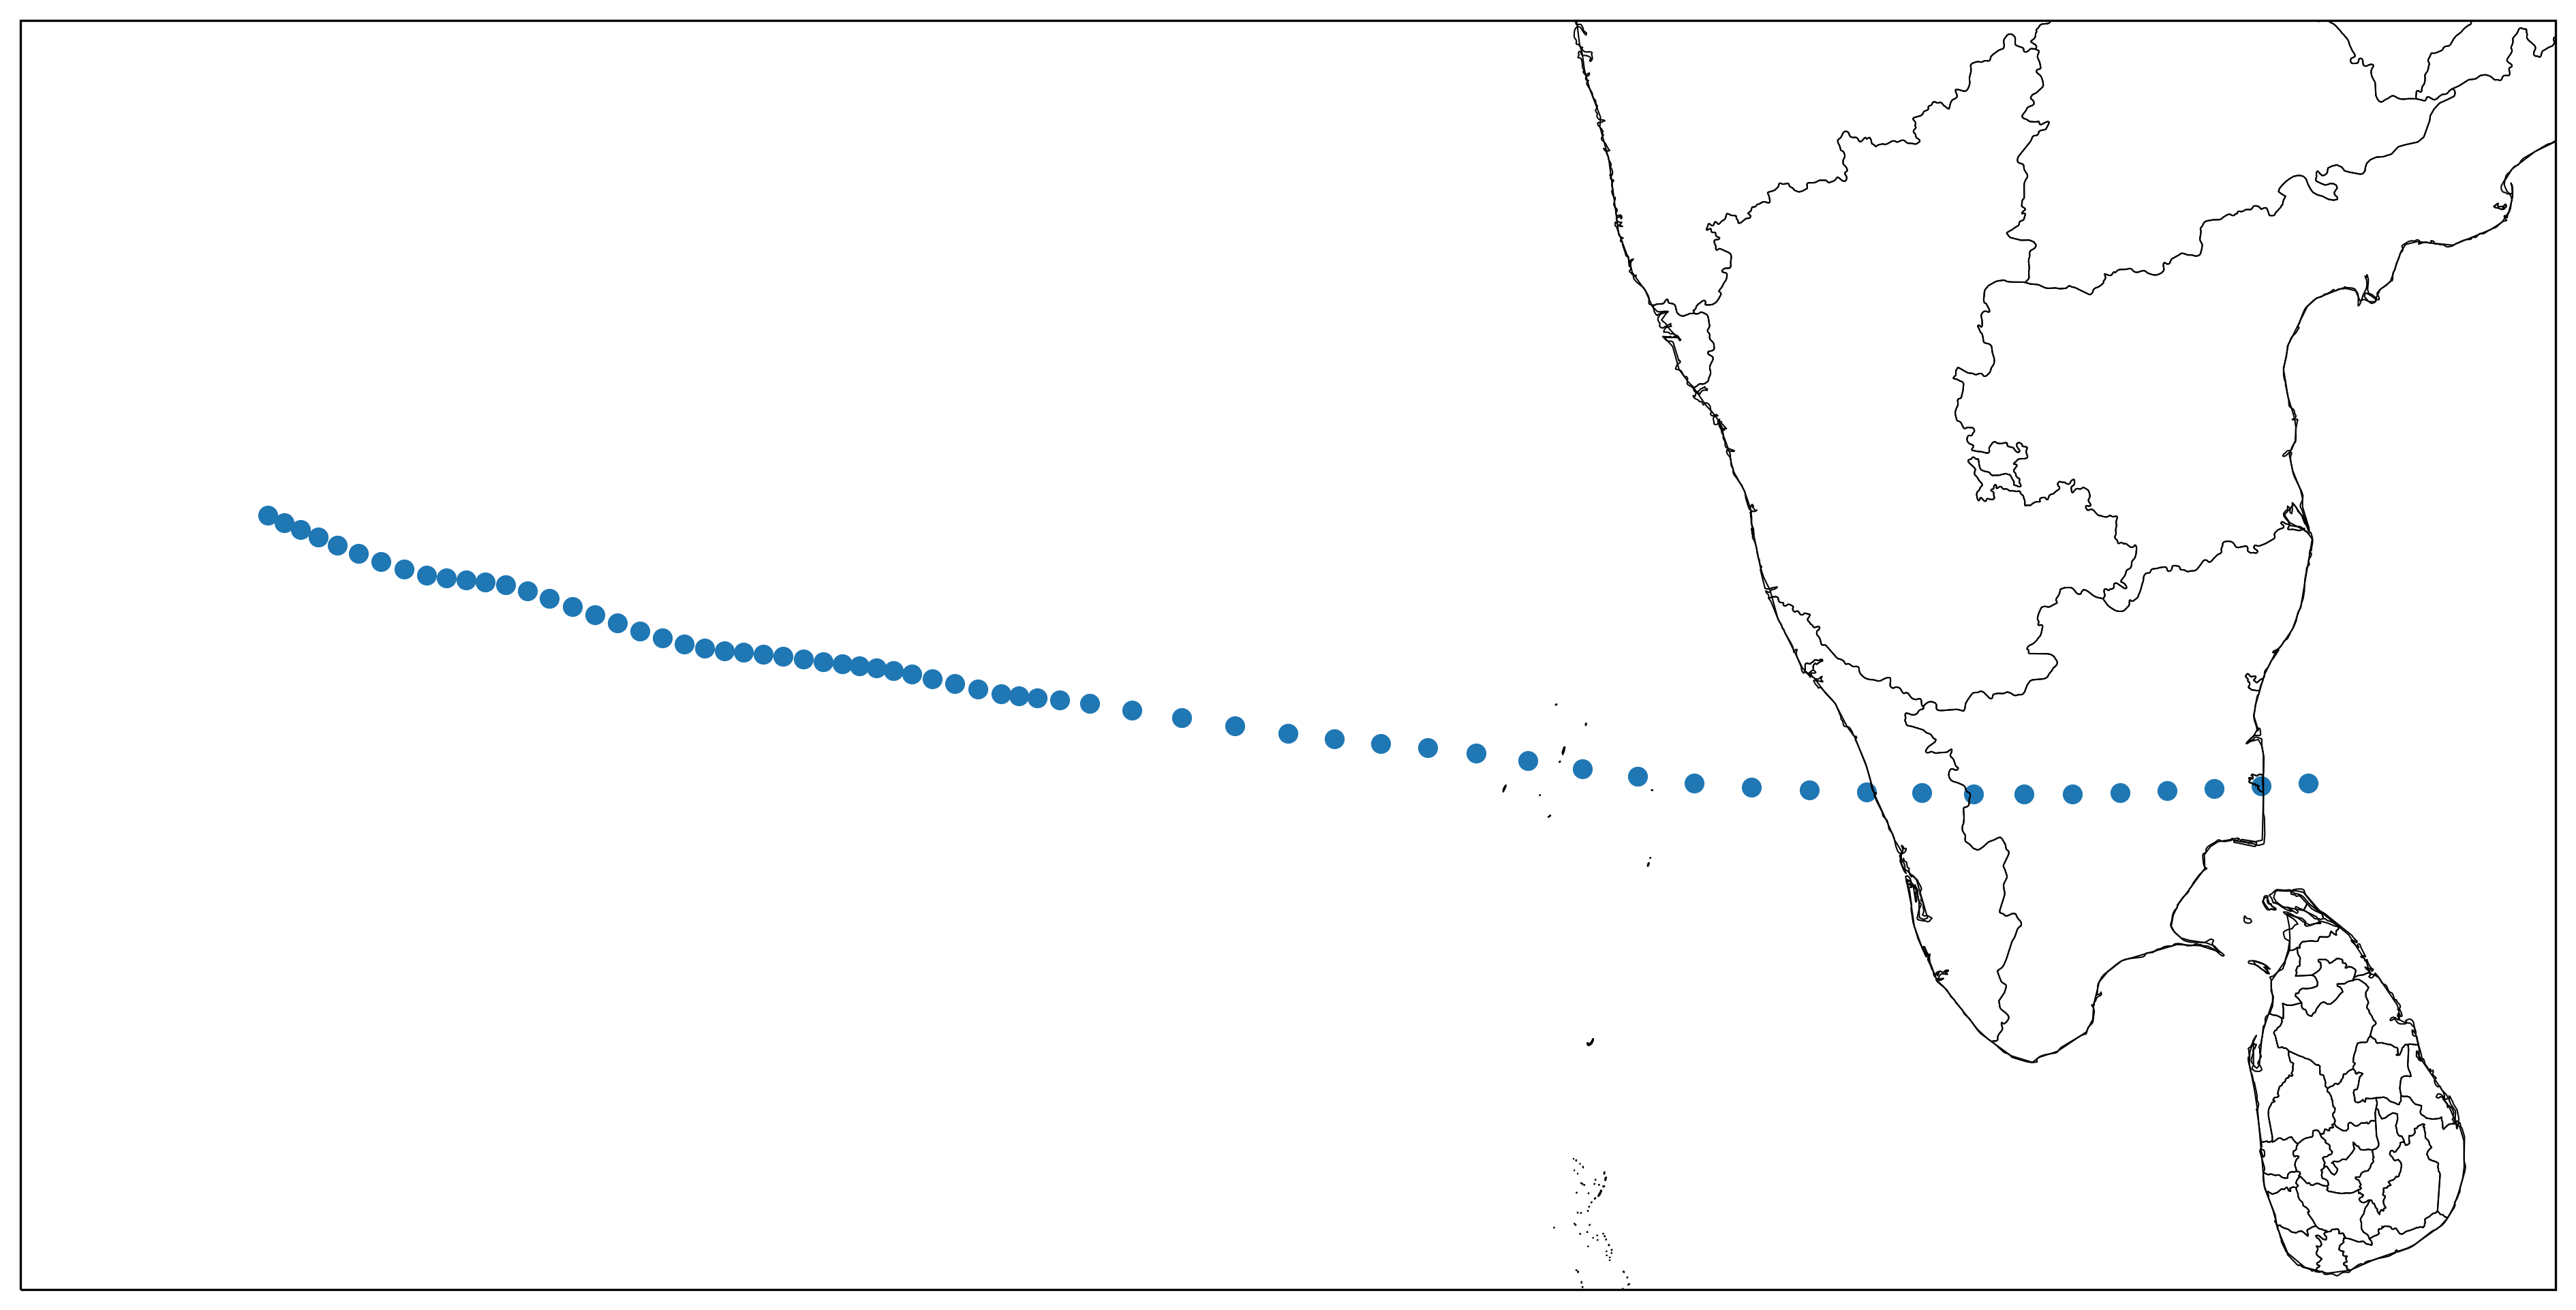

In [32]:
def plot_background(xmin, xmax, ymin, ymax, ax):
    ax.set_extent([xmin-2.5, xmax+2.5, ymin-5, ymax+5])
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
    ax.add_feature(cfeature.STATES, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    return ax

data = ibtracs_ds.isel(storm=0)
lats = data.lat.values
lons = data.lon.values

# Set up figure, basemap, etc.
proj=ccrs.PlateCarree(globe=None)
fig, ax = plt.subplots(figsize=(16,12), dpi=300, subplot_kw=dict(projection=proj))
plot_background(min(lons), max(lons), min(lats), max(lats), ax)

data.plot.scatter(x='lon', y='lat', transform=proj, ax=ax)
plt.show()

In [18]:
# Create function to index by storm (slice by lat/lon bounds, datetime, etc.)
# Colin's idea: pick out storm from ibtracs and use that to index tempest extremes 
# (possibly by using min slp for lat/lon bounding box)

# Read in ibtracs data

# Plot difference in storms (try to make sure translation speed is well represented)

In [86]:
ibtracs = "../tempest_extremes/IBTrACS.ALL.v04r00.nc"
ibtracs_ds = xr.open_dataset(ibtracs, drop_variables=ibtracs_vars).load()
since80_ds = ibtracs_ds.loc[dict(date_time=ibtracs_ds.date_time, storm=ibtracs_ds.storm[(ibtracs_ds['time.year'] >= 1980)[:,0]])]
#since80_ds = since80_ds['usa_lon360'] = np.mod(since80_ds['usa_lon']+360,360)
since80_ds

<xarray.Dataset>
Dimensions:     (storm: 4572, date_time: 360)
Coordinates:
    time        (storm, date_time) datetime64[ns] 1980-01-01T00:00:00.0000404...
    lat         (storm, date_time) float32 -12.5 -12.19 -11.91 ... nan nan nan
    lon         (storm, date_time) float32 172.5 172.4 172.4 ... nan nan nan
Dimensions without coordinates: storm, date_time
Data variables: (12/28)
    numobs      (storm) float32 41.0 13.0 79.0 9.0 69.0 ... 51.0 29.0 47.0 45.0
    sid         (storm) |S13 b'1980001S13173' ... b'2022083S13076'
    season      (storm) float32 1.98e+03 1.98e+03 ... 2.022e+03 2.022e+03
    number      (storm) int16 1 2 3 4 5 6 7 8 9 ... 11 12 13 14 15 16 17 18 19
    name        (storm) |S128 b'PENI' b'DANITZA' ... b'CHARLOTTE' b'HALIMA'
    source_usa  (storm) |S128 b'bsh051980.txt' ... b'BOTH_tcvitals.txt:Line=1...
    ...          ...
    usa_agency  (storm, date_time) |S32 b'jtwc_sh' b'' b'jtwc_sh' ... b'' b''
    usa_lat     (storm, date_time) float32 -12.5 -12.18 -11.9 ... nan nan nan
    usa_lon     (storm, date_time) float32 172.5 172.4 172.4 ... nan nan nan
    usa_status  (storm, date_time) |S2 b'' b'' b'' b'' b'' ... b'' b'' b'' b''
    usa_wind    (storm, date_time) float32 25.0 25.0 25.0 25.0 ... nan nan nan
    usa_pres    (storm, date_time) float32 nan nan nan nan ... nan nan nan nan
Attributes: (12/50)
    title:                      IBTrACS - International Best Track Archive fo...
    summary:                    The intent of the IBTrACS project is to overc...
    source:                     The original data are tropical cyclone positi...
    Conventions:                ACDD-1.3
    Conventions_note:           Data are nearly CF-1.7 compliant. The sole is...
    product_version:            v04r00
    ...                         ...
    license:                    These data may be redistributed and used with...
    featureType:                trajectory
    cdm_data_type:              Trajectory
    comment:                    The tracks of TCs generally look like a traje...
    nco_openmp_thread_number:   1
    NCO:                        4.4.3

In [375]:
katrina = ibtracs_ds.where(((ibtracs_ds.name==b'KATRINA') &\
                            (ibtracs_ds.season==2005)), drop=True)
katrina = katrina.sel(storm=[0])

In [104]:
ibtracs_ds['lon'].values.shape

# date_time is dimension of max timesteps per storm

(13607, 360)

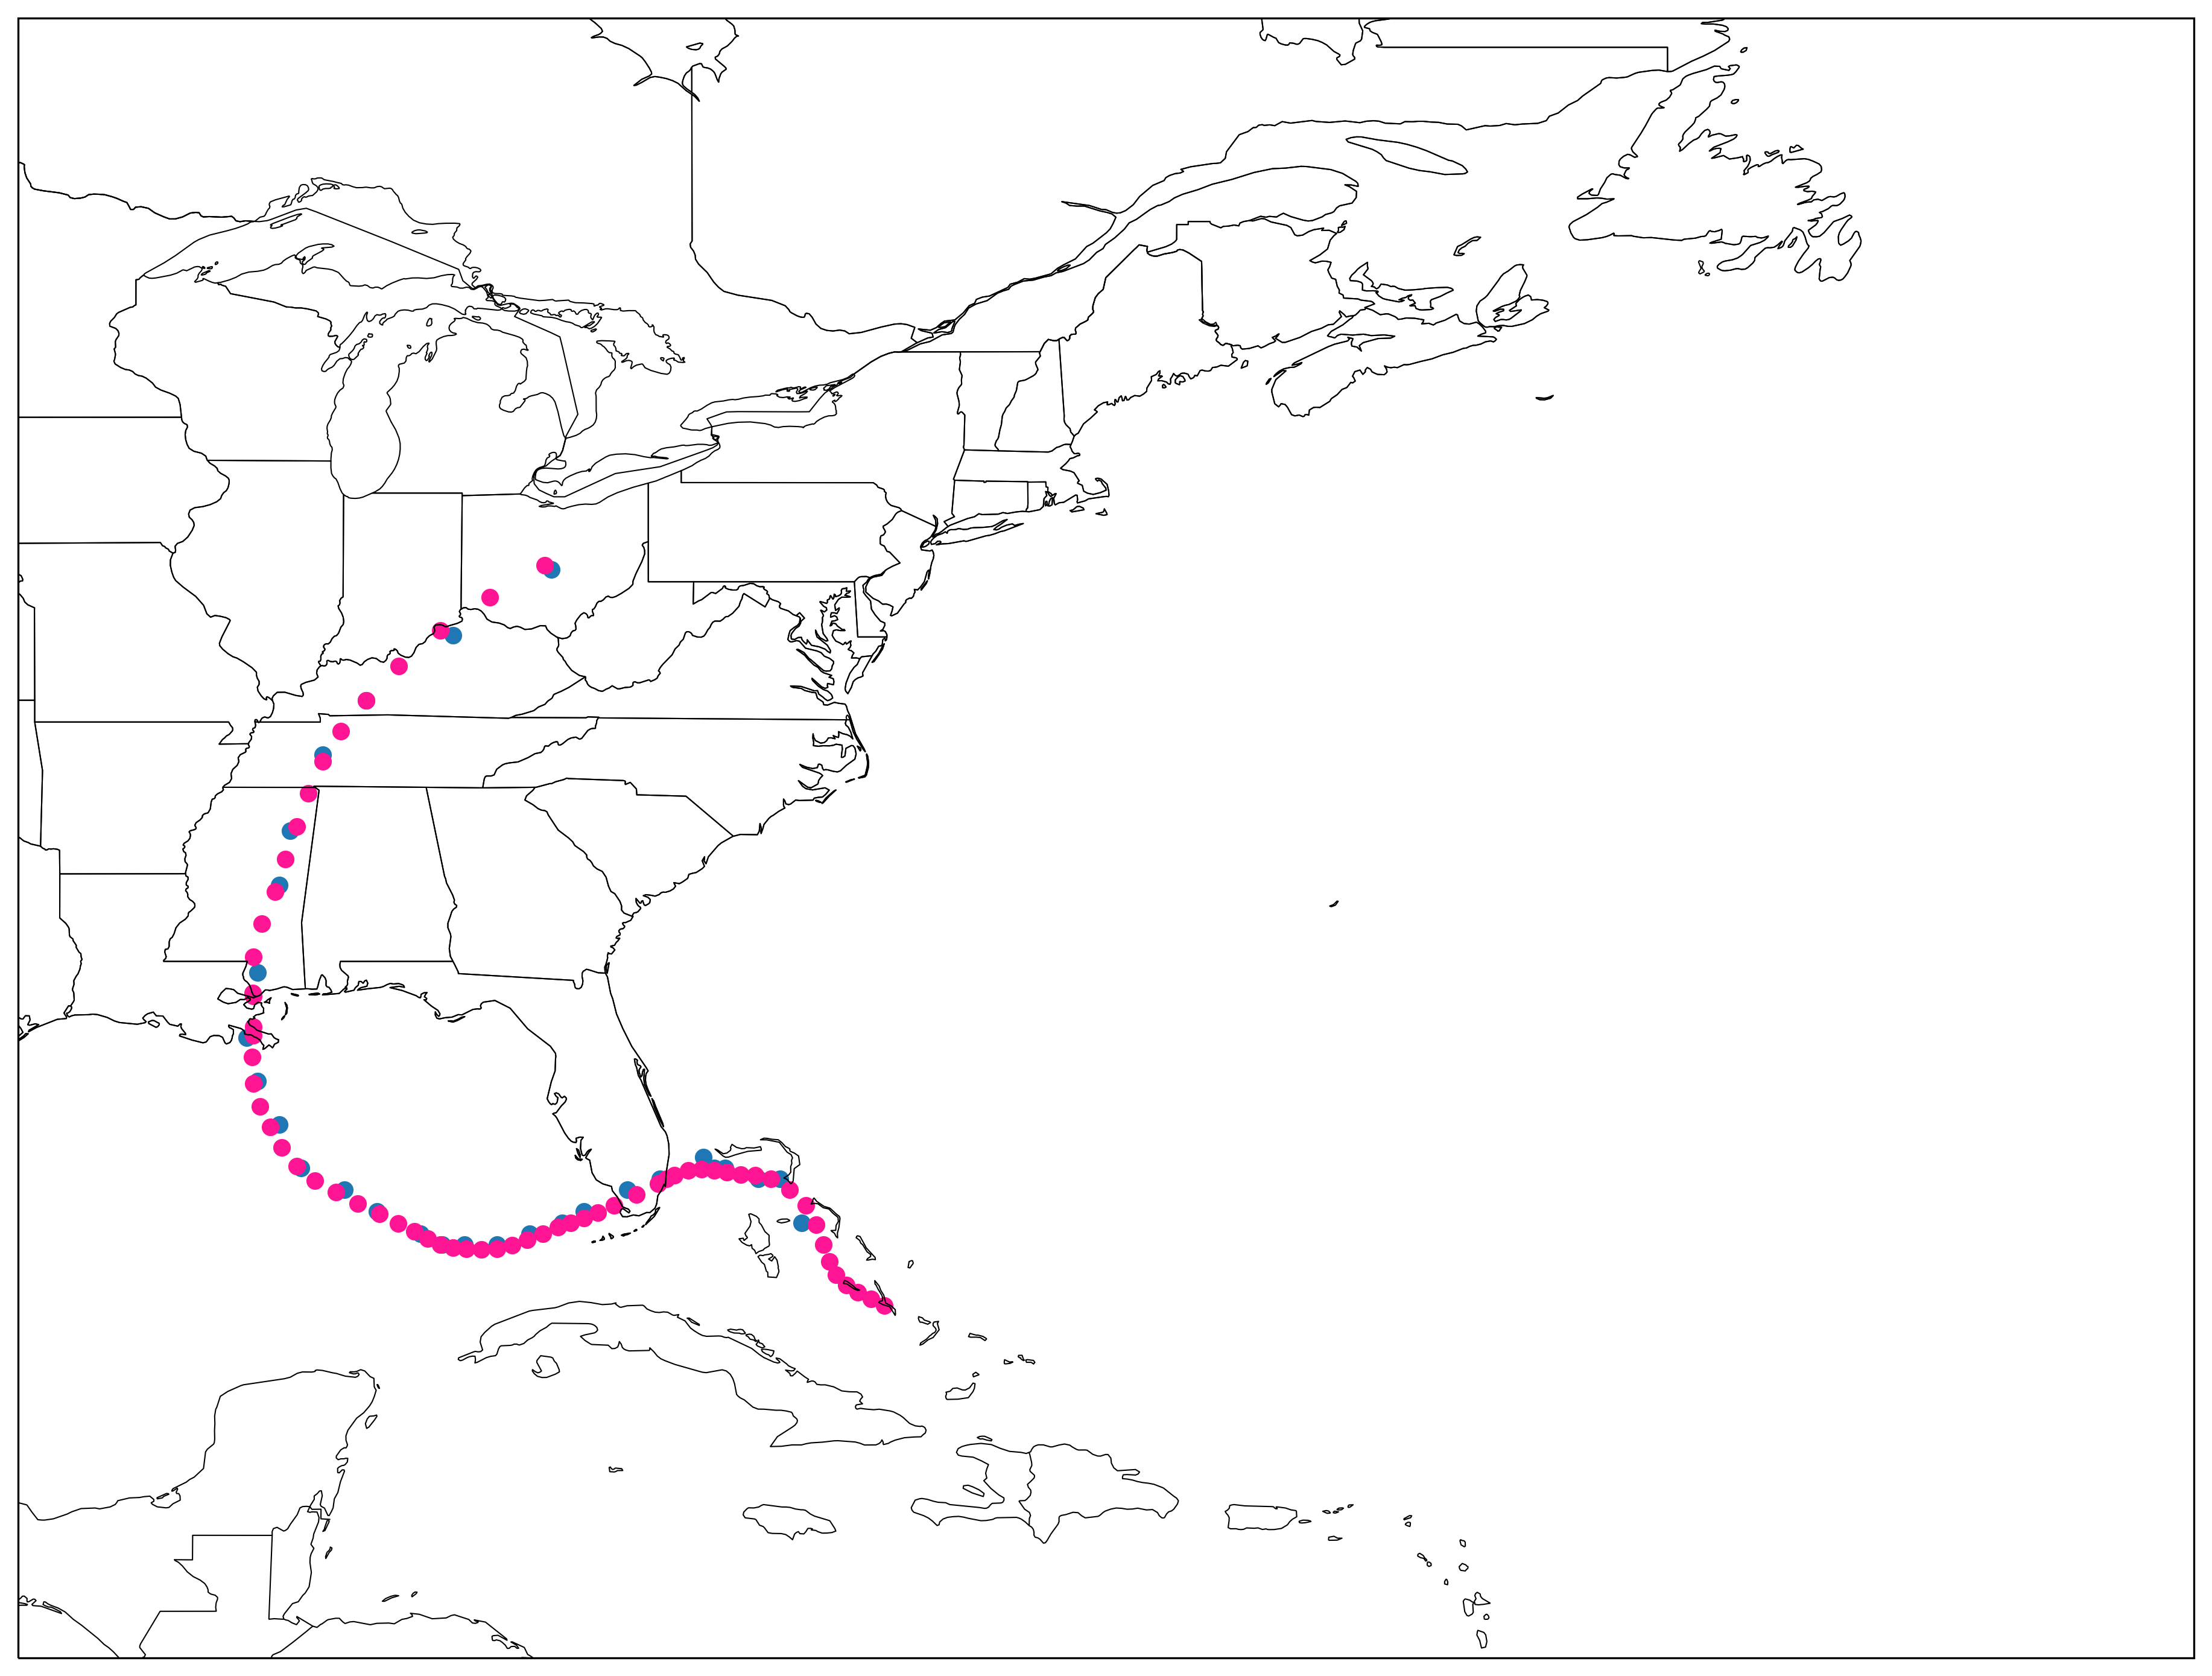

In [388]:
def plot_background(ax):
    ax.set_extent([265., 315., 15., 50.])
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
    ax.add_feature(cfeature.STATES, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    return ax

# Set up figure, basemap, etc.
fig = plt.figure(figsize=(16, 12), dpi=300)
proj=ccrs.PlateCarree(globe=None)
ax = fig.add_subplot(1,1,1,projection=proj)
plot_background(ax)

subset = ERA5_ds.where(((ERA5_ds.time.dt.year==2005) &\
                               (ERA5_ds.time.dt.month==8)), drop=True)
i=9
subset.sel(storm=[i]).plot.scatter('lon', 'lat', transform=proj)
katrina.plot.scatter('lon', 'lat', transform=proj, color='deeppink')

plt.show()

In [257]:
ERA5_ds['time'][0].values[0] == np.datetime64('1980-01-06')

numpy.datetime64('1980-01-06T06:00:00.000000000')

In [259]:
np.datetime64('1980-01-06') == datetime(1980,1,6)

False

In [175]:
ERA5_ds['time'][0].values[0].astype('datetime64[ns]')

numpy.datetime64('1980-01-06T06:00:00.000000000')

In [173]:
ERA5_ds['time'][0].values[0]

numpy.datetime64('1980-01-06T06:00:00.000000000')

In [177]:
np.datetime64('1980-08').astype('datetime64[ns]')

numpy.datetime64('1980-08-01T00:00:00.000000000')

In [241]:
ERA5_ds.time.dt.year == 2012

<xarray.DataArray 'year' (storm: 3084, date_time: 107)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
    time     (storm, date_time) datetime64[ns] 1980-01-06T06:00:00 ... NaT
    lon      (storm, date_time) float64 120.5 119.0 119.0 119.2 ... nan nan nan
    lat      (storm, date_time) float64 -14.25 -14.75 -15.0 ... nan nan nan
Dimensions without coordinates: storm, date_time

In [243]:
ERA5_ds.sel(ERA5_ds.coords['time'] == '2011')

ValueError: the first argument to .sel must be a dictionary

In [ ]:
def ibtracs_date_indexing(start, end=None):
    if type(start) == int and len(start) == 4:
        print(f'Indexing by year: {start}')
    elif type(start) == tuple:
        print(f'Indexing by year: {start[0]}, month: {start[1]}')

In [267]:
(2018,1,10)[0]

2018

In [307]:
ERA5_ds.sel(time=slice('2011', '2012'))

KeyError: 'no index found for coordinate time'

In [304]:
ERA5_dt = ERA5_ds.time.dt


test = ERA5_ds.where(((ERA5_dt.year==2005) & (ERA5_dt.month==8)), 
                      drop=True)
test

<xarray.Dataset>
Dimensions:     (storm: 14, date_time: 38)
Coordinates:
    time        (storm, date_time) datetime64[ns] 2005-07-28T06:00:00 ... 200...
    lon         (storm, date_time) float64 113.0 113.2 113.2 ... -39.25 -38.0
    lat         (storm, date_time) float64 18.5 17.75 18.5 ... 41.75 43.0 44.25
Dimensions without coordinates: storm, date_time
Data variables:
    pressure    (storm, date_time) float64 nan nan nan nan ... nan nan nan nan
    wind_speed  (storm, date_time) float64 nan nan nan nan ... nan nan nan nan

In [275]:
ERA5_ds

<xarray.Dataset>
Dimensions:     (storm: 3084, date_time: 107)
Coordinates:
    time        (storm, date_time) datetime64[ns] 1980-01-06T06:00:00 ... NaT
    lon         (storm, date_time) float64 120.5 119.0 119.0 ... nan nan nan
    lat         (storm, date_time) float64 -14.25 -14.75 -15.0 ... nan nan nan
Dimensions without coordinates: storm, date_time
Data variables:
    pressure    (storm, date_time) float64 9.988e+04 9.981e+04 ... nan nan
    wind_speed  (storm, date_time) float64 14.65 13.99 13.7 ... nan nan nan

In [254]:
datetime(2011, 12, 25)

datetime.datetime(2011, 12, 25, 0, 0)